In [1]:
#!/C/Users/kremin/Anaconda3/python.exe
# coding: utf-8

# Basic Walkthrough:
#      1) Define everything
#      2) Create master bias file, Save master bias file  
#      3) Open all other files, sub master bias, save  (*c?.b.fits)
#      4) Remove cosmics from all file types except bias  (*c?.bc.fits)
#      5) Open flats and create master skyflat file, save
#      6) Open all remainging types and divide out master flat, then save  (*c?.bcf.fits)
#      7) Open all remaining types and stitch together, save  (*full.bcf.fits)
#      8) Use fibermap files to determine aperatures
#      9) Use aperatures to cut out same regions in thar,comp,science
#      10) Save all 256 to files with their header tagged name in filename, along with fiber num
#      11) Assume no curvature within tiny aperature region; fit profile to 2d spec and sum to 1d
#      12) Fit the lines in comp spectra, save file and fit solution
#      13) Try to fit lines in thar spectra, save file and fit solution
#      14) Apply to science spectra



In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pickle as pkl

from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.ndimage.filters import median_filter





In [3]:


from quickreduce_funcs import get_all_filedata, print_data_neatly,                               save_hdu,get_dict_temp


# ### Define input file numbers and other required information
# 
# Ex:
# 
#     Bias 597-626
#     ThAr 627,635
#     NeHgArXe 628,629,636,637
#     Science 631-634
#     Fibermaps 573-577
# 



In [4]:


biass = np.arange(597,626+1).astype(int)
thar_lamps = np.asarray([627,635])
comp_lamps = np.asarray([628,629,636,637])
twiflats = np.arange(582,591+1).astype(int)
sciences = np.arange(631,634+1).astype(int)
fibermaps = np.arange(573,577+1).astype(int)




In [5]:


instrument = 'M2FS'
mask_name = 'A02'
config = '11C'
# cal_lamp = ['Xe', 'Ar', 'HgNe', 'Hg', 'Ne']
cal_lamp = ['HgAr', 'NeAr']
# cal_lamp = ['HgAr', 'NeAr', 'Ar', 'Xe']
# cal_lamp = ['Xenon','Argon','Neon', 'HgNe']
# cal_lamp = ['Xe', 'Ar', 'HgNe', 'Hg', 'Ne']
# thar_lamp = ['Th','ThAr']
thar_lamp = ['ThAr']
cameras = ['r']
opamps = [1,2,3,4]




In [6]:


path_to_masks = os.path.abspath('../../OneDrive/Research/M2FSReductions')
mask_subdir = mask_name
raw_data_subdir =  'raw_data'
filename_template = {}
filename_template['raw'] = '{cam}{filenum:04d}c{opamp}.fits'




In [7]:


make_debug_plots = False
print_headers = True
cut_bias_cols = True
convert_adu_to_e = True
load_data_from_disk_each_step = False




In [8]:


do_step = OrderedDict()
do_step['stitch'] = False
do_step['bias'] = False
do_step['remove_crs']   = False
do_step['ffmerge'] = False
do_step['apcut'] = False
do_step['wavecalib'] = False
do_step['flat'] = False
do_step['combine'] = False
do_step['zfit'] = False


# ###         Beginning of Code



In [9]:


date = np.datetime_as_string(np.datetime64('today', 'D'))




In [10]:


directory = {}
directory['mask'] = os.path.join(path_to_masks,mask_subdir)




In [11]:


directory['raw_data'] =     os.path.join(directory['mask'], raw_data_subdir)
directory['raw_stitched'] = os.path.join(directory['mask'],'raw_stitched')
directory['product'] =      os.path.join(directory['mask'],'data_products')
directory['twod'] =         os.path.join(directory['mask'],'twods')
directory['oned'] =         os.path.join(directory['mask'],'oneds')
directory['calibrated'] =   os.path.join(directory['mask'],'calibrated_oned')
directory['summedspec'] =   os.path.join(directory['mask'],'final_oned')
directory['zfit'] =         os.path.join(directory['mask'],'zfits')
directory['linelists'] = os.path.join(os.curdir,'lamp_linelists','salt')

for dirpath in directory.values():
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)




In [12]:


filenumbers = {'bias':biass, 'thar':thar_lamps, 'comp': comp_lamps,
               'twiflat':twiflats, 'science': sciences, 'fibmap': fibermaps}




In [13]:


filename_template['base'] =      '{cam}_{imtype}_{filenum:04d}_{maskname}_'
filename_template['stitched'] =  filename_template['base']+'stitched{tags}.fits'
filename_template['twod'] =      filename_template['base']+'{fibername}_2d{tags}.fits'
filename_template['oned'] =      filename_template['base']+'1d{tags}.fits'
filename_template['combined'] =  filename_template['base']+'{fibername}_combined_1d{tags}.fits'
filename_template['linelist'] =  '{lamp}.txt'

filename_template['master_stitched'] =  '{cam}_master{imtype}_{maskname}_stitched{tags}.fits'




In [14]:


setup_info  =      {    'maskname':         mask_name,
                        'cameras':          cameras,
                        'opamps':           opamps, 
                        'deadfibers':       None          }

load_info   =       {   'datadir':          directory['raw_data'],
                        'template':         filename_template['raw'],
                        'tags':             ''            }

save_info   =       {   'date':             date,
                        'datadir':          directory['raw_stitched'],
                        'template':         filename_template['stitched'],
                        'tags':             ''             }

master_info  =      {   'master_template':  filename_template['master_stitched'],
                        'master_types':     []             }




In [15]:


start = 'stitch'
for key,val in do_step.items():
    if val:
        start = key
        break


# ### How the hdudict is structured
# 
#     dict_of_hdus  
#          keys: science, comp, thar, flat, fibmap
#          vals: cameras_dict
#               
#          cameras_dict 
#                 keys: r, b
#                 vals: filenumbers_dict
#                            
#                 filenumbers_dict 
#                         keys: integer numbers
#                         vals: opampdict
#                                             
#                         opampdict 
#                                keys: ints 1, 2, 3, 4
#                                vals: hdus for each of 4 opamps



In [16]:


## Now that stitching is complete. opamps = None
if 'bias' in filenumbers.keys():
    filenumbers.pop('bias')
#if 'bias' not in master_info['master_types']:
#    master_info['master_types'].append('bias')
    
setup_info['opamps'] = None

In [17]:


filenumbers.pop('fibmap')
#master_info['master_types'].append('fibmap')

load_info['tags'] = '.bc'
save_info['tags'] = '.bc'  
load_info['datadir'] = directory['oned']
save_info['datadir'] = directory['oned']
load_info['template'] = filename_template['oned']
save_info['template'] = filename_template['oned']


In [18]:


dict_of_hdus = get_all_filedata(filenum_dict=filenumbers,fibersplit=True,
                                **setup_info,**load_info,**master_info)
print_data_neatly(dict_of_hdus)
blank_dictofdicts = get_dict_temp(dict_of_hdus)

with open('_temp_fine_wavecalib.pkl','rb') as pklin:
    calibs = pkl.load(pklin)
    all_coefs = calibs[0]
    all_covs = calibs[1]
    all_coefs_table = Table(all_coefs)





thar
	r
		627
			datatype = <class 'astropy.io.fits.hdu.table.BinTableHDU'>
		635
			datatype = <class 'astropy.io.fits.hdu.table.BinTableHDU'>
comp
	r
		628
			datatype = <class 'astropy.io.fits.hdu.table.BinTableHDU'>
		629
			datatype = <class 'astropy.io.fits.hdu.table.BinTableHDU'>
		636
			datatype = <class 'astropy.io.fits.hdu.table.BinTableHDU'>
		637
			datatype = <class 'astropy.io.fits.hdu.table.BinTableHDU'>
twiflat
	r
		582
			datatype = <class 'astropy.io.fits.hdu.table.BinTableHDU'>
		583
			datatype = <class 'astropy.io.fits.hdu.table.BinTableHDU'>
		584
			datatype = <class 'astropy.io.fits.hdu.table.BinTableHDU'>
		585
			datatype = <class 'astropy.io.fits.hdu.table.BinTableHDU'>
		586
			datatype = <class 'astropy.io.fits.hdu.table.BinTableHDU'>
		587
			datatype = <class 'astropy.io.fits.hdu.table.BinTableHDU'>
		588
			datatype = <class 'astropy.io.fits.hdu.table.BinTableHDU'>
		589
			datatype = <class 'astropy.io.fits.hdu.table.BinTableHDU'>
		590
			datatype = <

In [19]:


import seaborn
def fifthorder(xs,a,b,c,d,e,f):
    return  a + b*xs + c*xs*xs + \
            d*np.power(xs,3)   + \
            e*np.power(xs,4)   + \
            f*np.power(xs,5)

from quickreduce_funcs import format_plot





r101
r102
r103
r104
r105
r106
r107
r108
r109
r110
r111
r112


C:\Users\kremin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


r113
r114
r115
r116
r201
r202
r203
r204
r205
r206
r207
r208
r209
r210
r211
r212
r213
r214
r215
r216
r301
r302
r303
r304
r305
r306
r307
r308
r309
r310
r311
r312
r313
r314
r315


<Figure size 432x288 with 0 Axes>

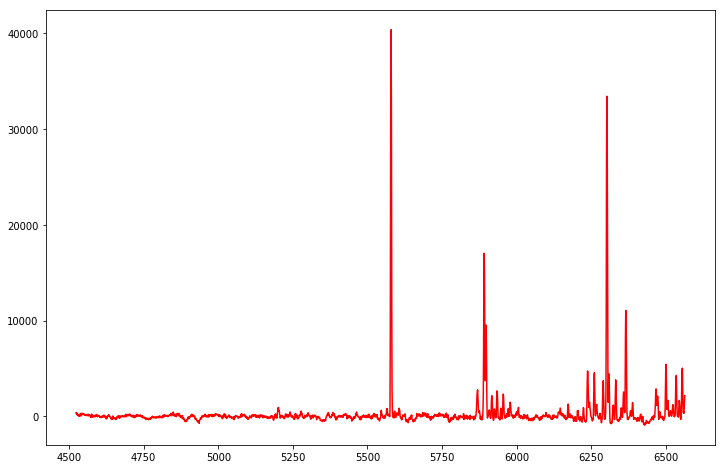

<Figure size 432x288 with 0 Axes>

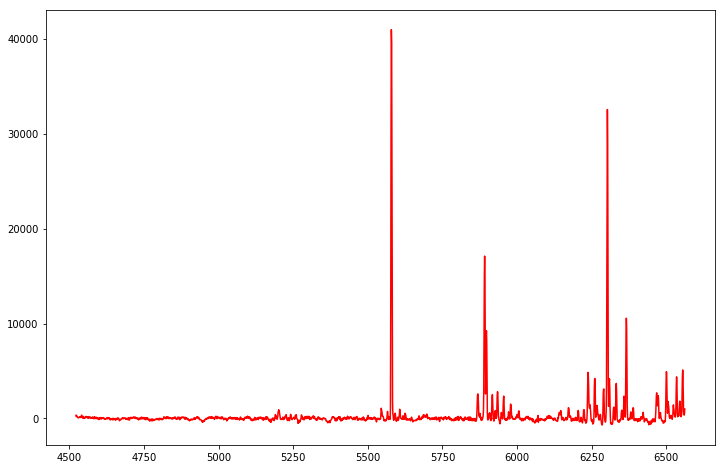

<Figure size 432x288 with 0 Axes>

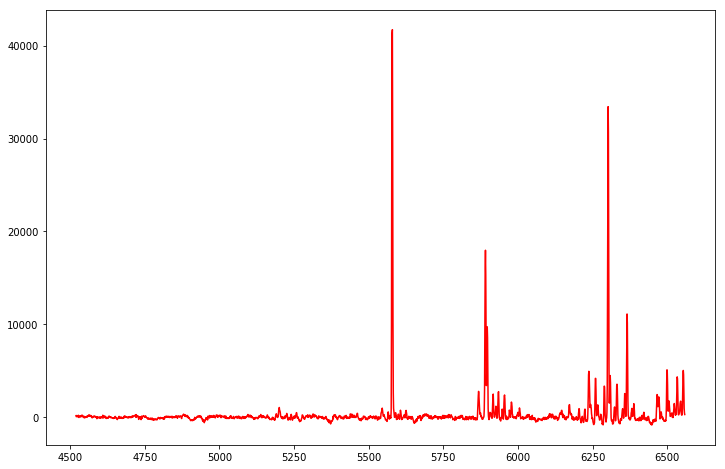

<Figure size 432x288 with 0 Axes>

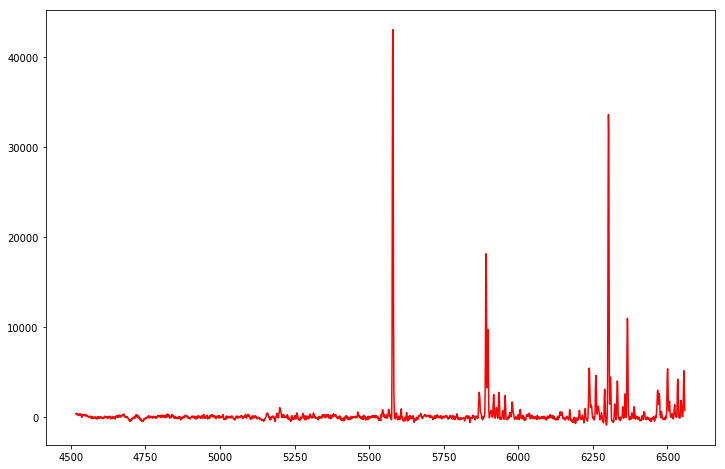

<Figure size 432x288 with 0 Axes>

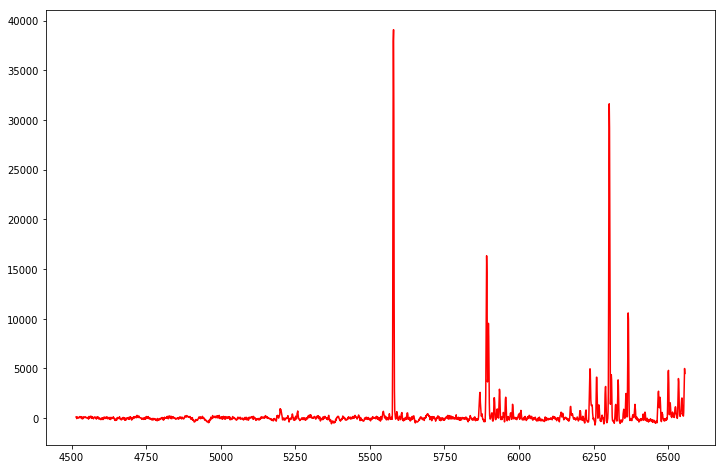

<Figure size 432x288 with 0 Axes>

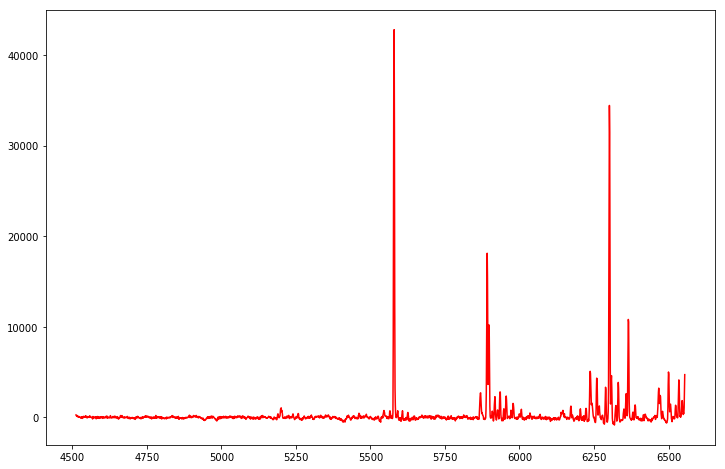

<Figure size 432x288 with 0 Axes>

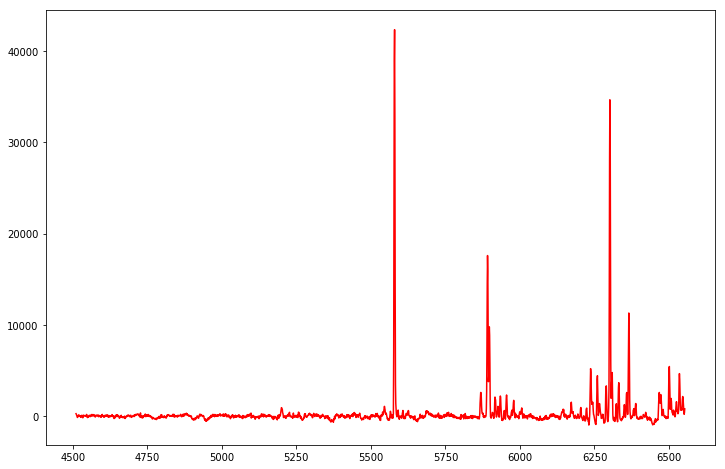

<Figure size 432x288 with 0 Axes>

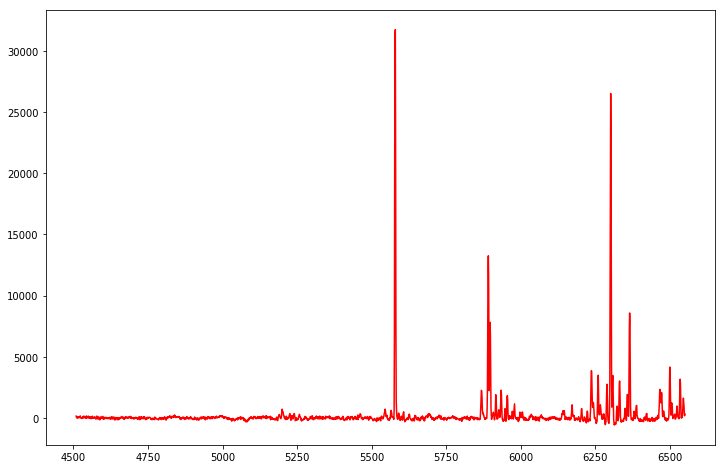

<Figure size 432x288 with 0 Axes>

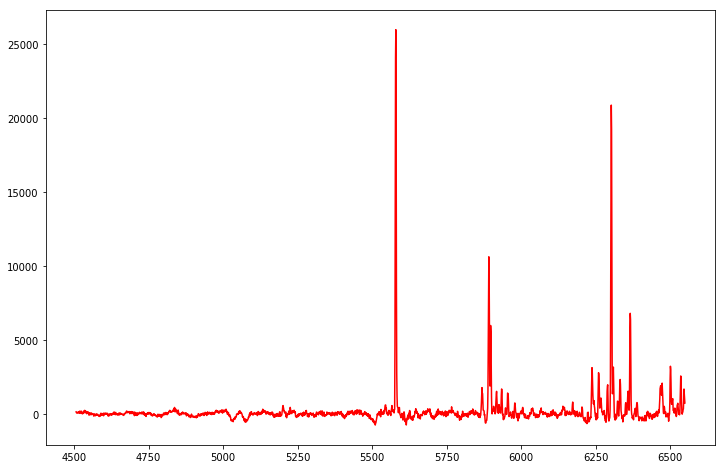

<Figure size 432x288 with 0 Axes>

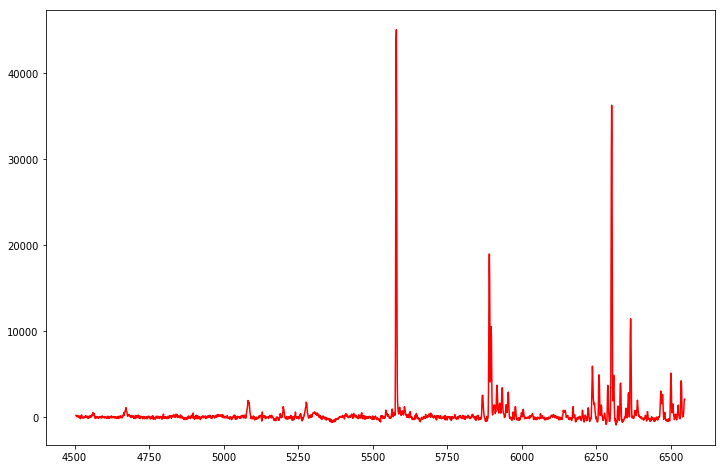

<Figure size 432x288 with 0 Axes>

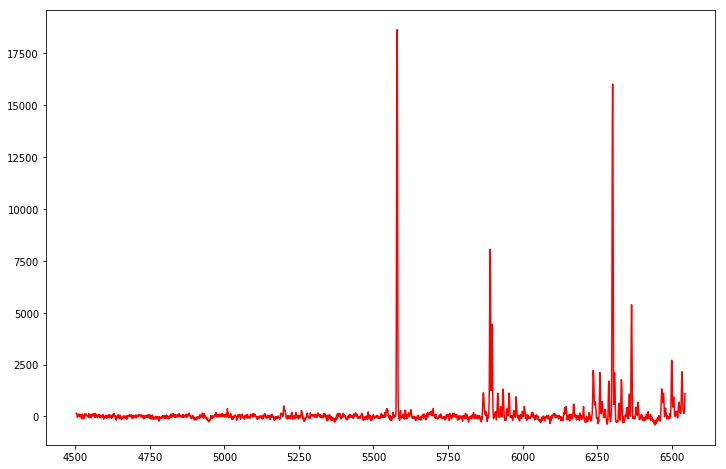

<Figure size 432x288 with 0 Axes>

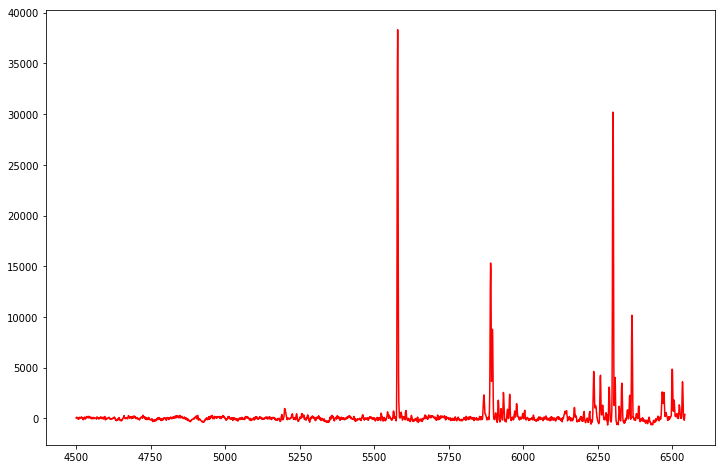

<Figure size 432x288 with 0 Axes>

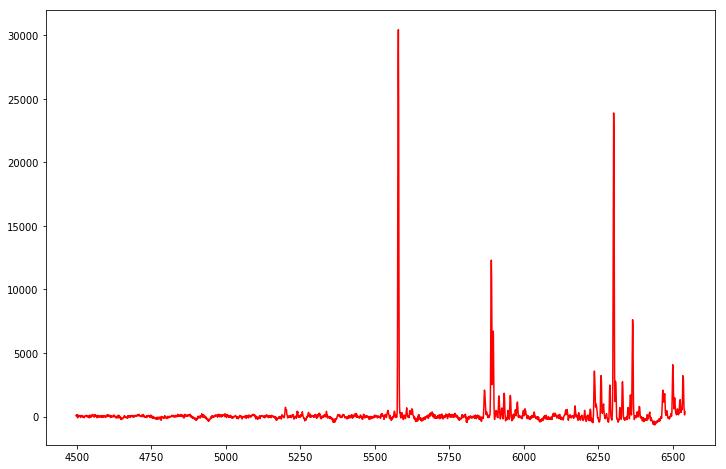

<Figure size 432x288 with 0 Axes>

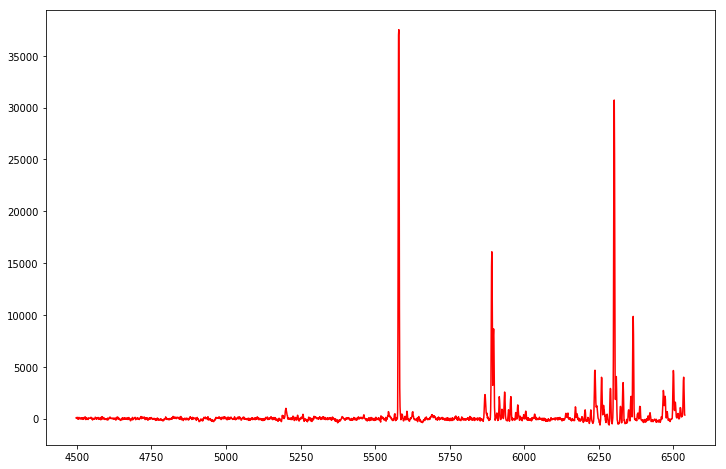

<Figure size 432x288 with 0 Axes>

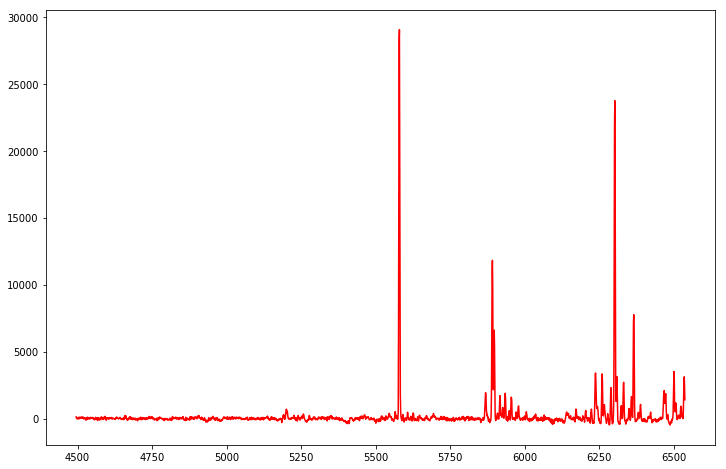

<Figure size 432x288 with 0 Axes>

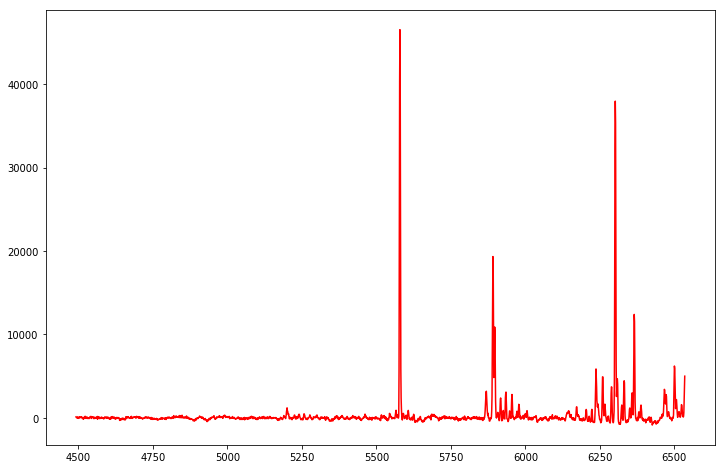

<Figure size 432x288 with 0 Axes>

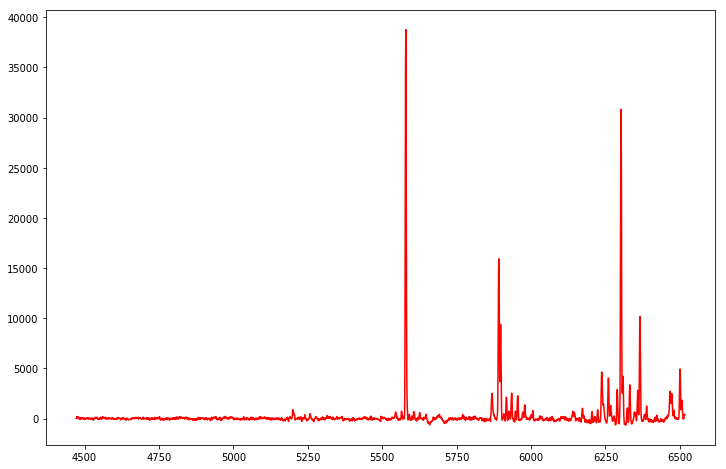

<Figure size 432x288 with 0 Axes>

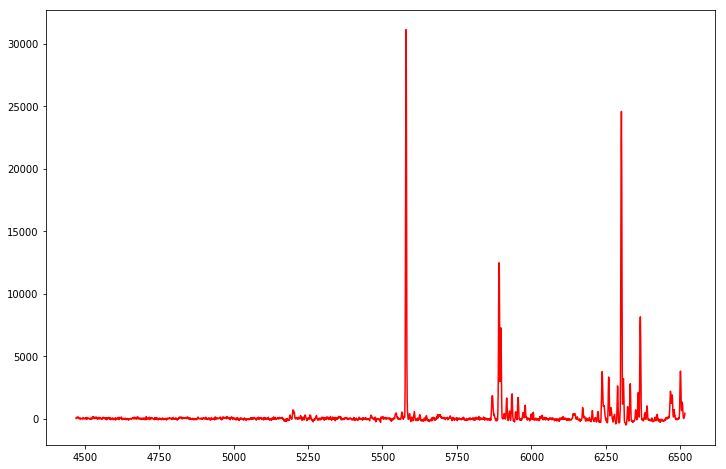

<Figure size 432x288 with 0 Axes>

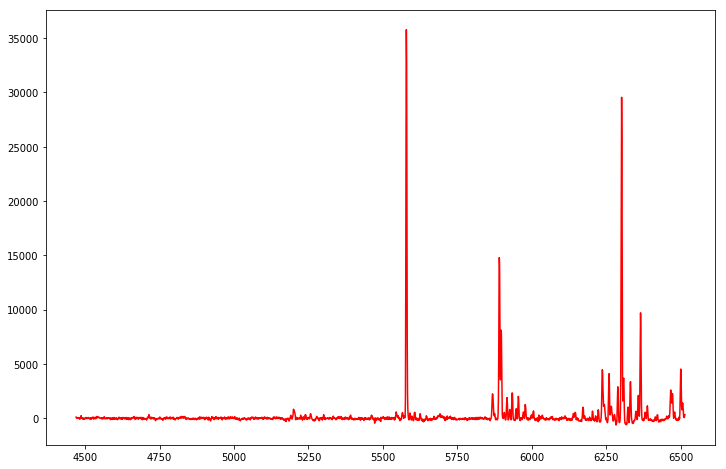

<Figure size 432x288 with 0 Axes>

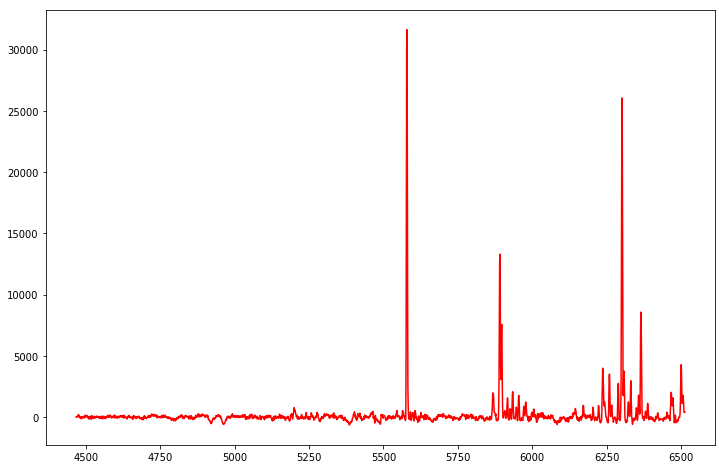

<Figure size 432x288 with 0 Axes>

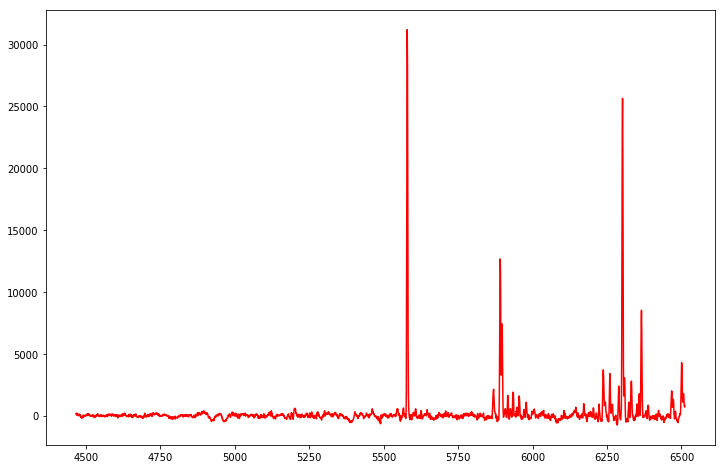

<Figure size 432x288 with 0 Axes>

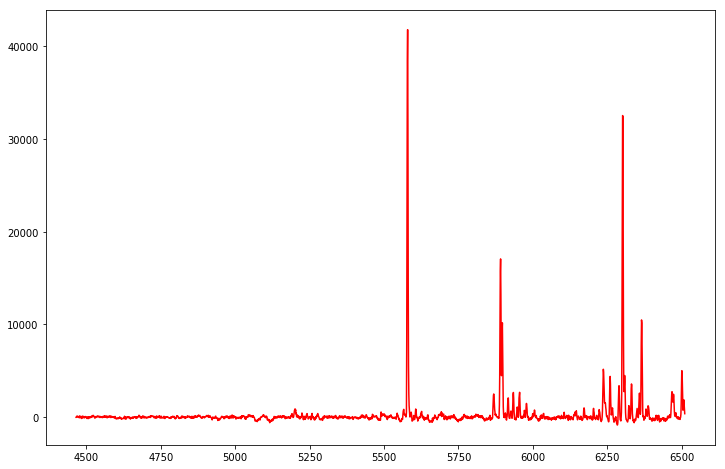

<Figure size 432x288 with 0 Axes>

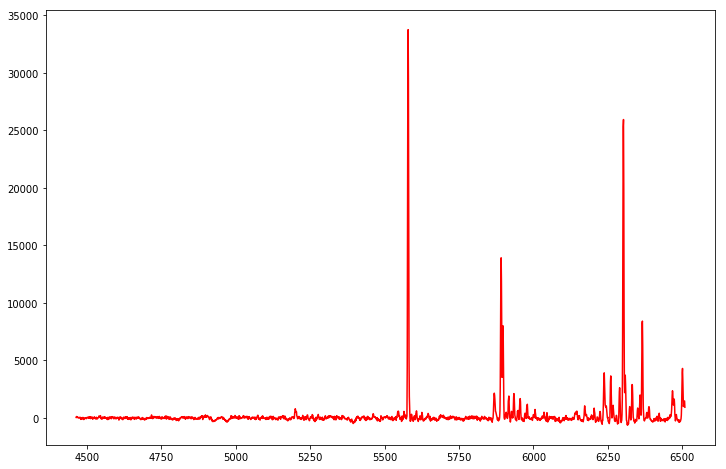

<Figure size 432x288 with 0 Axes>

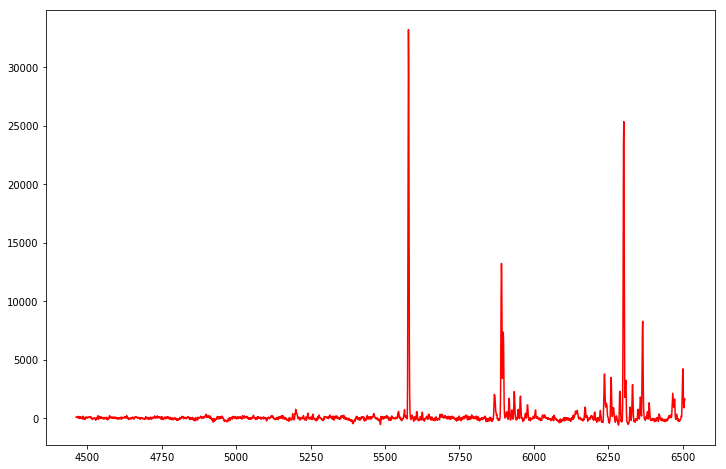

<Figure size 432x288 with 0 Axes>

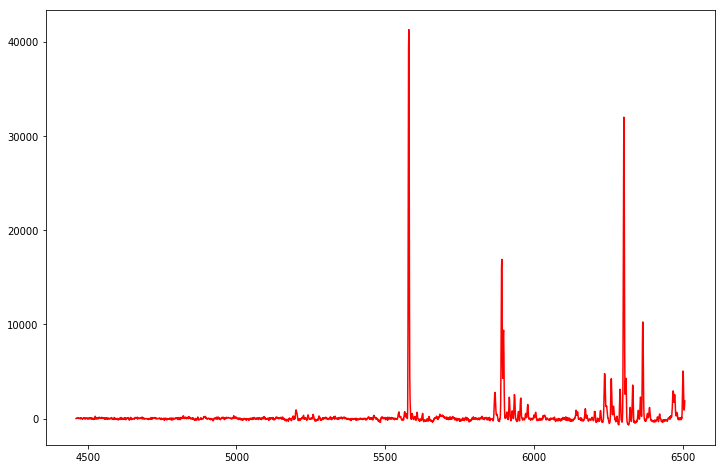

<Figure size 432x288 with 0 Axes>

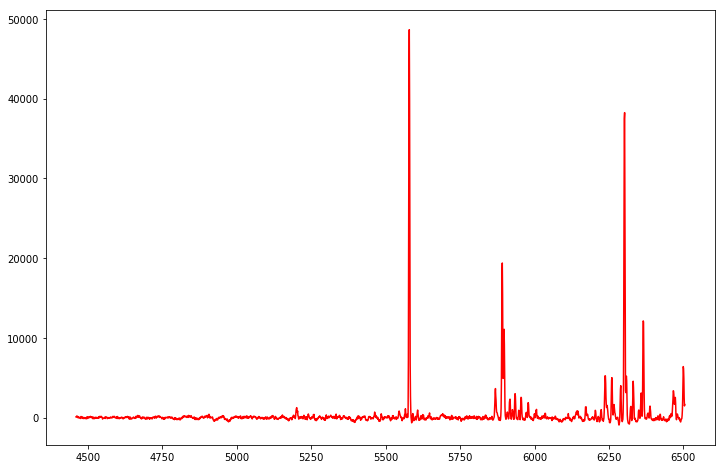

<Figure size 432x288 with 0 Axes>

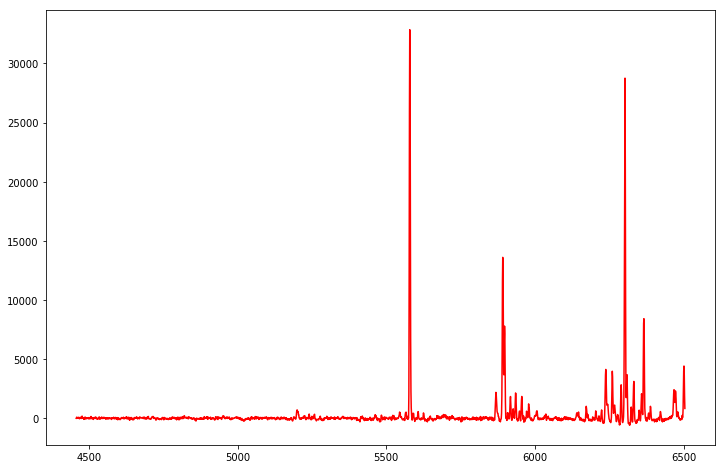

<Figure size 432x288 with 0 Axes>

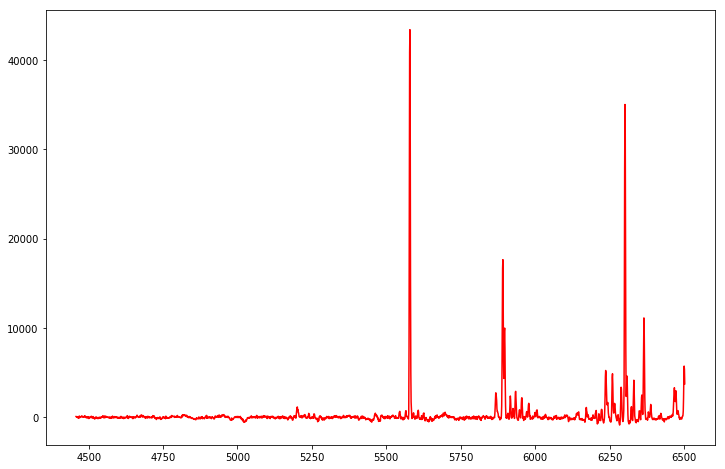

<Figure size 432x288 with 0 Axes>

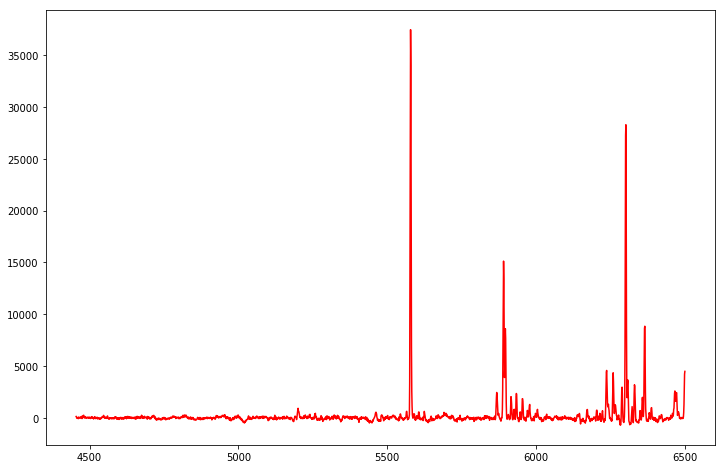

<Figure size 432x288 with 0 Axes>

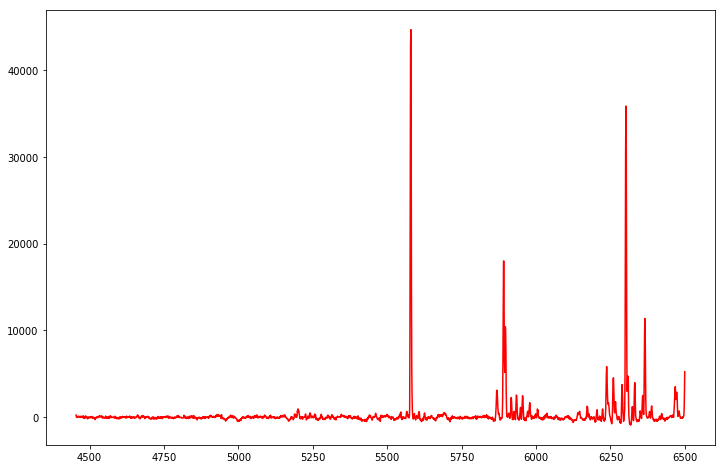

<Figure size 432x288 with 0 Axes>

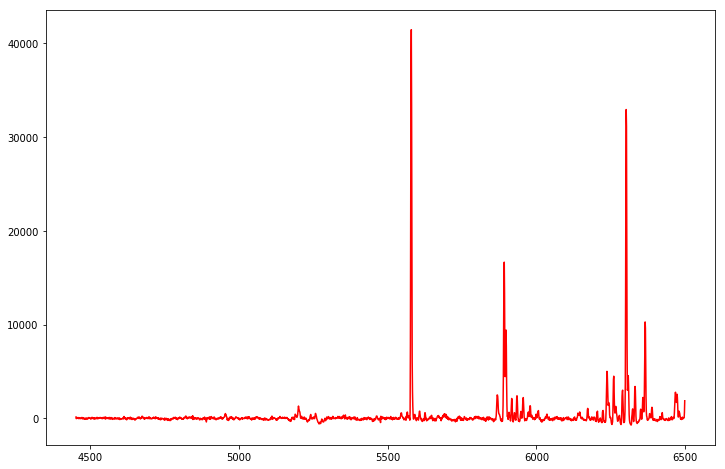

<Figure size 432x288 with 0 Axes>

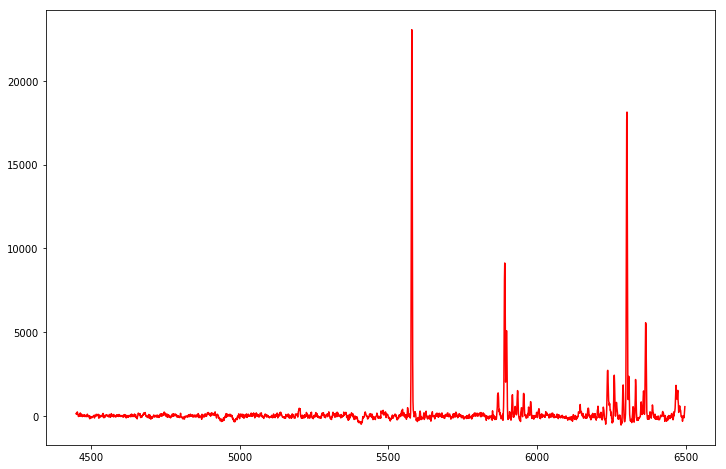

<Figure size 432x288 with 0 Axes>

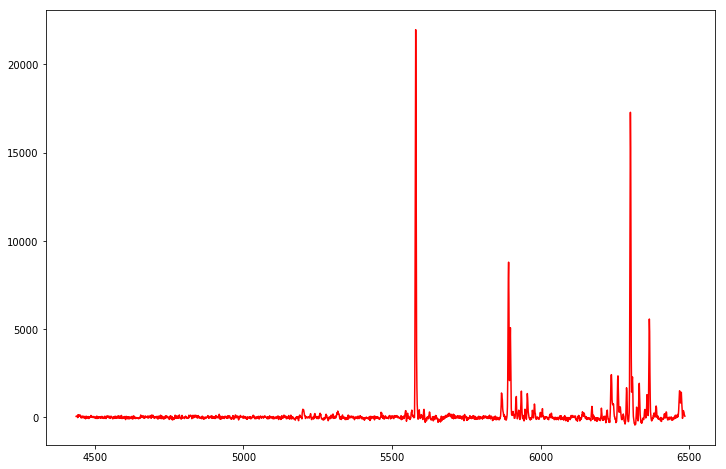

<Figure size 432x288 with 0 Axes>

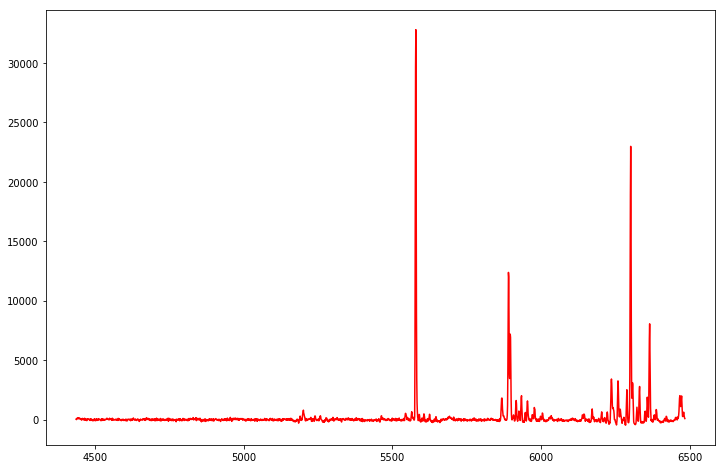

<Figure size 432x288 with 0 Axes>

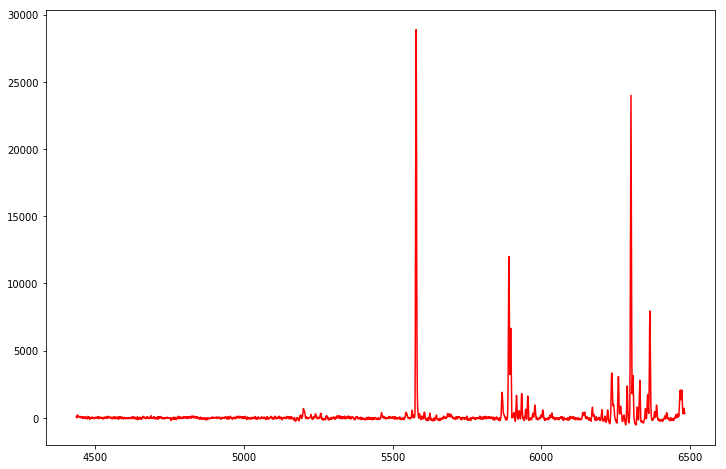

<Figure size 432x288 with 0 Axes>

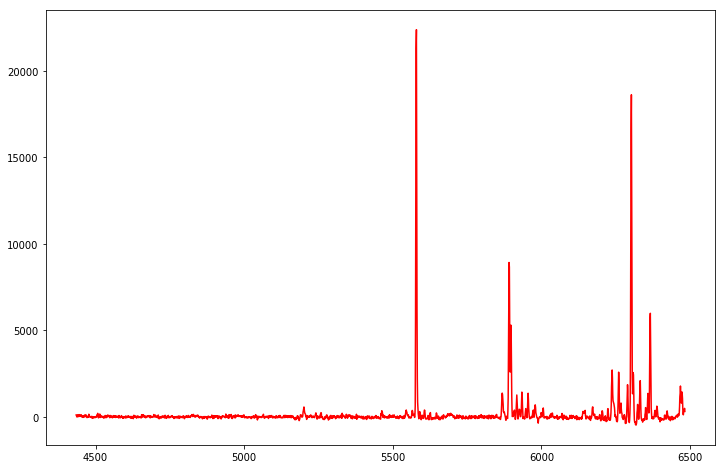

<Figure size 432x288 with 0 Axes>

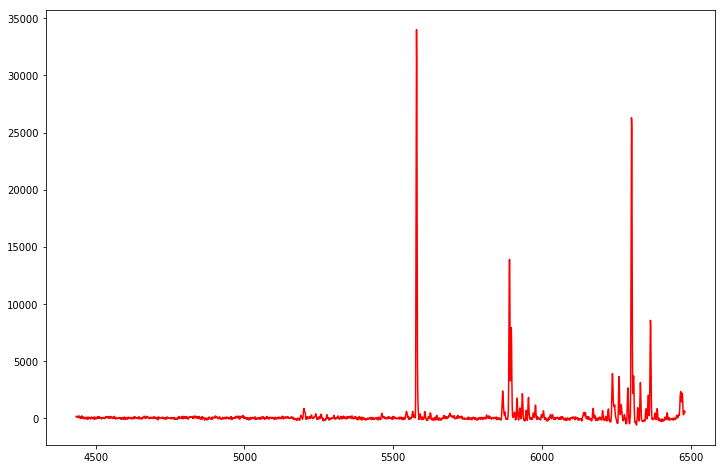

<Figure size 432x288 with 0 Axes>

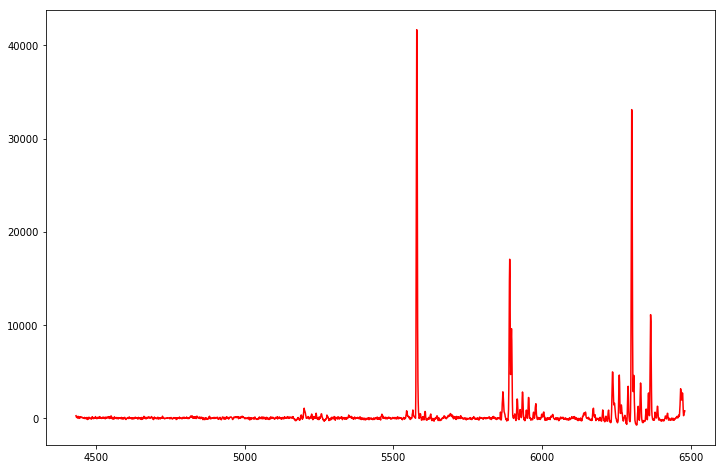

<Figure size 432x288 with 0 Axes>

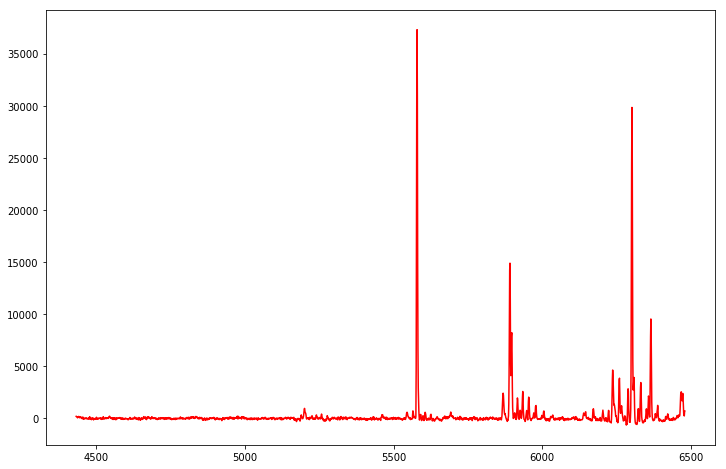

<Figure size 432x288 with 0 Axes>

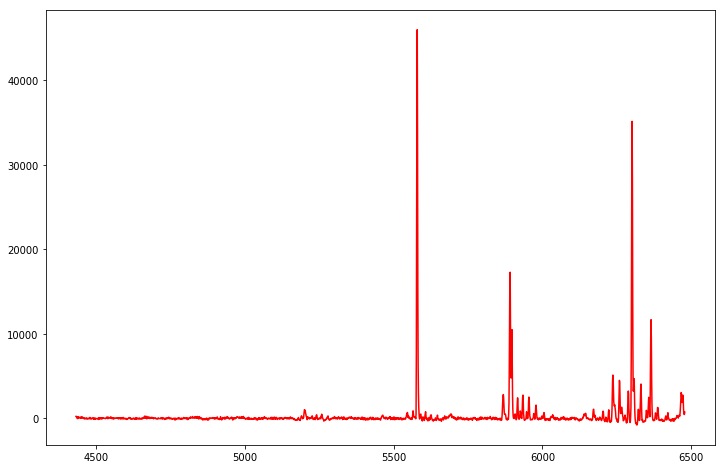

<Figure size 432x288 with 0 Axes>

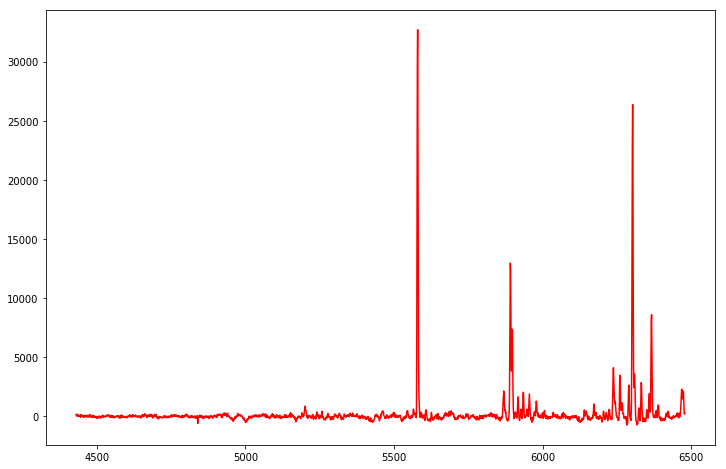

<Figure size 432x288 with 0 Axes>

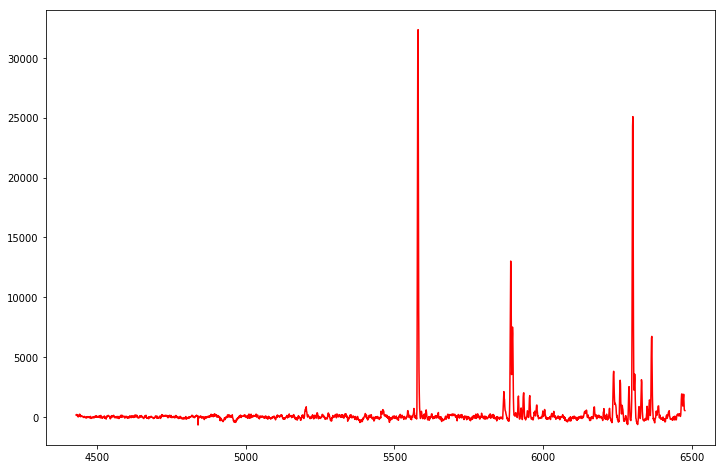

<Figure size 432x288 with 0 Axes>

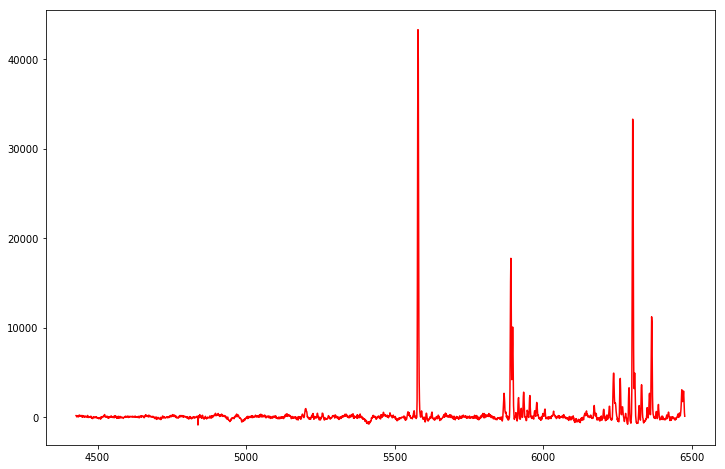

<Figure size 432x288 with 0 Axes>

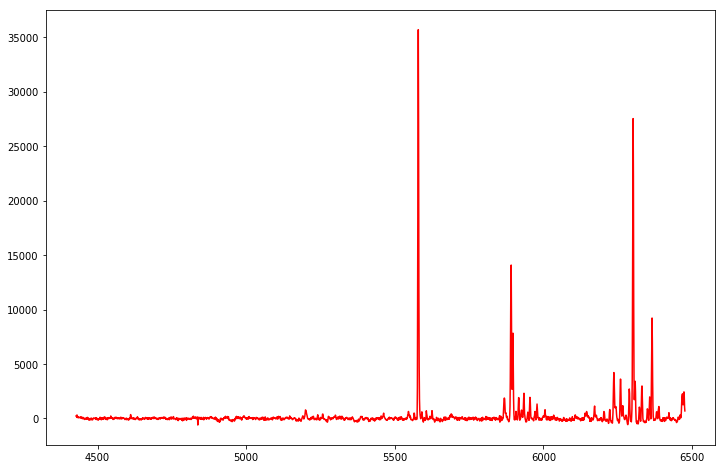

<Figure size 432x288 with 0 Axes>

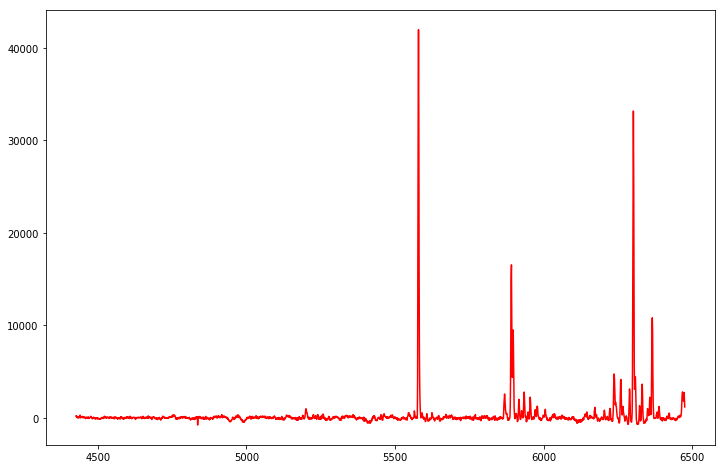

<Figure size 432x288 with 0 Axes>

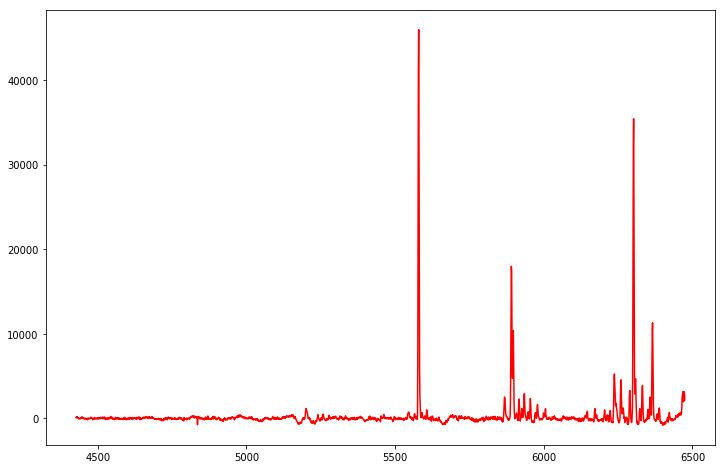

<Figure size 432x288 with 0 Axes>

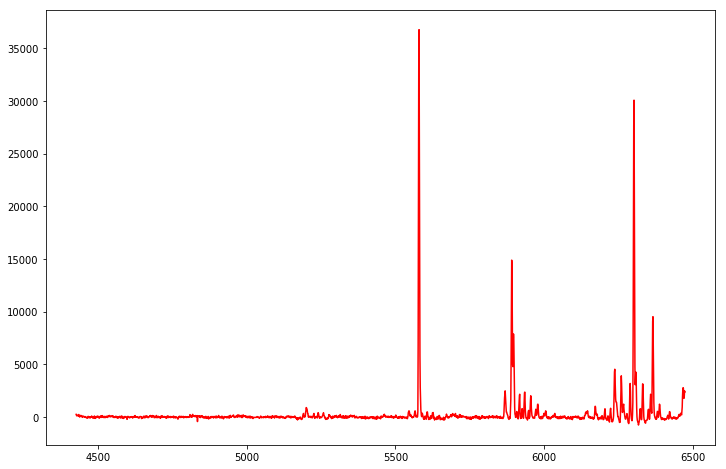

In [29]:
from scipy.signal import medfilt
sciences = {}
for ap in all_coefs_table.colnames:
    if ap == 'r316' or ap[1] in ['4','5']:
        continue
    #calib_spec = calib_cof
    science_array = dict_of_hdus['science']['r'][filenumbers['science'][0]].data[ap]
    
    for filenumber in filenumbers['science'][1:]:
        science_array += dict_of_hdus['science']['r'][filenumber].data[ap]
    pixels = np.arange(science_array.size).astype(np.float64)
    waves = fifthorder(pixels,*all_coefs_table[ap].data)
    flux = science_array - medfilt(science_array,171)
    sciences[ap] = [waves,flux]
    print(ap)
    plt.figure()
    fig, ax = plt.subplots(1,figsize=(12,8))
    #plt.plot(waves, science_array, 'b')
    plt.plot(waves,flux,'r')





In [38]:
header = dict_of_hdus['science']['r'][filenumbers['science'][0]].header
header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024 / length of dimension 1                          
NAXIS2  =                 2048 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  128 / number of table fields                         
BUNIT   = 'DU/PIXEL'                                                            
ORIGIN  = 'LCO/OCIW'                                                            
OBSERVER= 'Bailey/Tucker/Spencer/Olsz'                                          
TELESCOP= 'Clay    '                                                            
SITENAME= 'LCO     '        

In [21]:
galaxies = {}
skies = {}
check_skies = {}
for spectra in sciences.keys():
    fibname = 'FIBER'+spectra[1:]
    science_name = header[fibname]
    
    if science_name[:3] == 'GAL':
        galaxies[spectra] = science_name
    elif science_name[:3] == 'SKY':
        skies[spectra] = science_name
    elif science_name == 'unplugged':
        check_skies[spectra] = science_name
    else:
        print("No match found!")
print(galaxies,skies,check_skies)

{'r101': 'GAL162', 'r102': 'GAL002', 'r103': 'GAL150', 'r104': 'GAL001', 'r105': 'GAL148', 'r106': 'GAL161', 'r107': 'GAL149', 'r108': 'GAL134', 'r109': 'GAL153', 'r110': 'GAL086', 'r111': 'GAL125', 'r112': 'GAL126', 'r113': 'GAL068', 'r114': 'GAL067', 'r115': 'GAL087', 'r116': 'GAL151', 'r201': 'GAL019', 'r203': 'GAL051', 'r204': 'GAL102', 'r205': 'GAL122', 'r206': 'GAL182', 'r207': 'GAL168', 'r208': 'GAL173', 'r209': 'GAL093', 'r210': 'GAL110', 'r211': 'GAL013', 'r212': 'GAL141', 'r213': 'GAL034', 'r214': 'GAL158', 'r215': 'GAL035', 'r216': 'GAL159', 'r301': 'GAL018', 'r309': 'GAL069', 'r310': 'GAL057', 'r311': 'GAL143', 'r312': 'GAL066', 'r313': 'GAL171', 'r314': 'GAL056'} {'r202': 'SKY006', 'r315': 'SKY001'} {'r302': 'unplugged', 'r303': 'unplugged', 'r304': 'unplugged', 'r305': 'unplugged', 'r306': 'unplugged', 'r307': 'unplugged', 'r308': 'unplugged'}


In [22]:
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
find_peaks?

r302
r303
r304
r305
r306
r307
r308


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

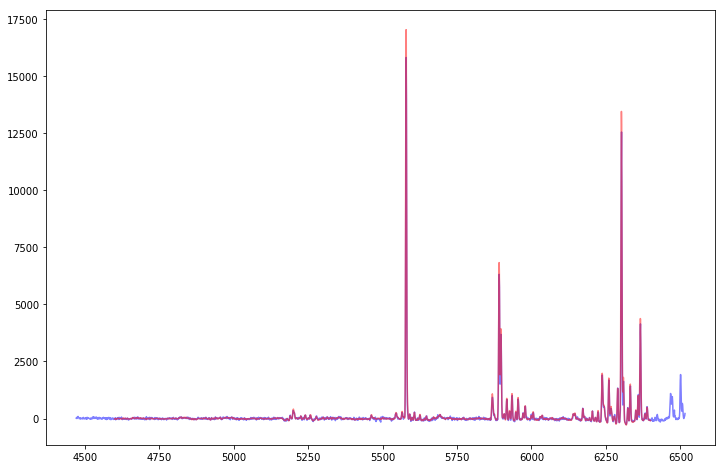

In [23]:
from scipy.interpolate import interp1d
#master_sky_wave, master_sky_flux = sciences['r202']
uniform_waves = np.arange(4600,6400,0.5)
interped_flux = interp1d(*sciences['r202'],assume_sorted = True)
master_sky_flux = interped_flux(uniform_waves)
nvals = 1
for ap in check_skies.keys():
    print(ap)
    nvals += 1
    plt.figure()
    interped_flux = interp1d(*sciences[ap],assume_sorted = True)
    itter_sky_flux = interped_flux(uniform_waves)
    master_sky_flux += itter_sky_flux
    #ratio = sciences[ap][1].max()/test_flux.max()
master_sky_flux /= nvals
fig, ax = plt.subplots(1,figsize=(12,8))
plt.plot(*sciences['r202'], 'b',alpha=0.5)
plt.plot(uniform_waves,master_sky_flux,'r',alpha=0.5)

r101
r102
r103
r104
r105
r106
r107
r108
r109
r110
r111
r112
r113
r114
r115
r116
r201
r203
r204
r205
r206
r207
r208
r209


C:\Users\kremin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


r210
r211
r212
r213
r214
r215
r216
r301
r309
r310
r311
r312
r313
r314


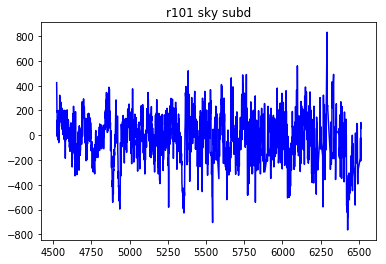

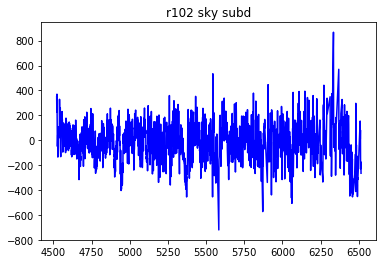

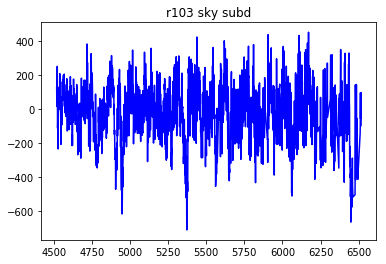

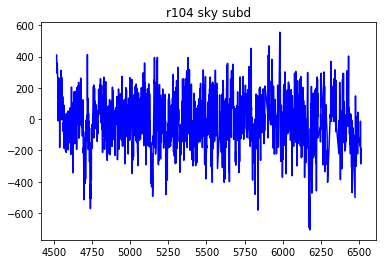

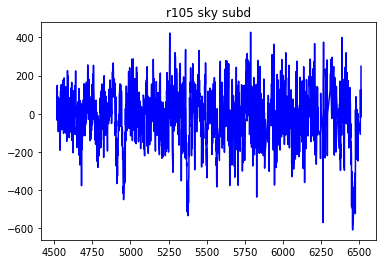

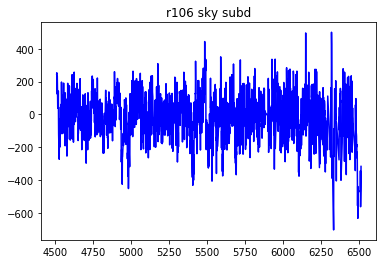

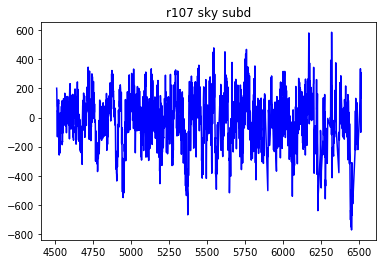

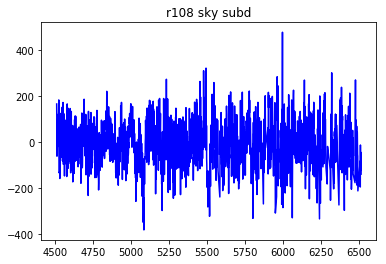

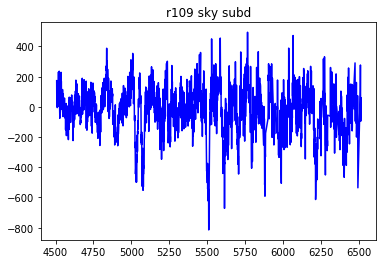

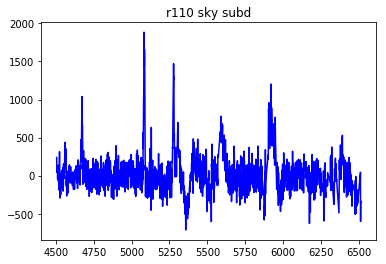

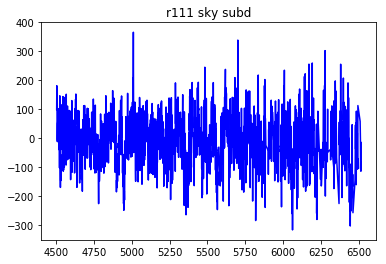

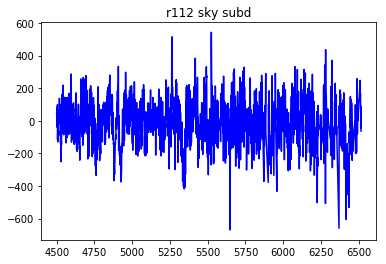

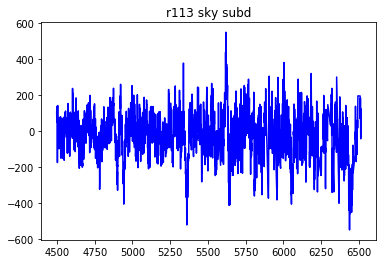

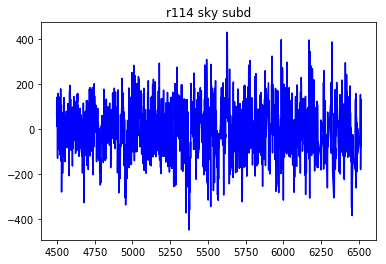

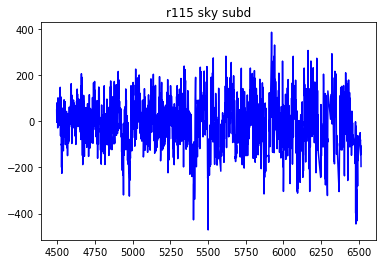

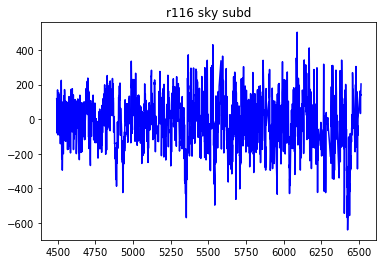

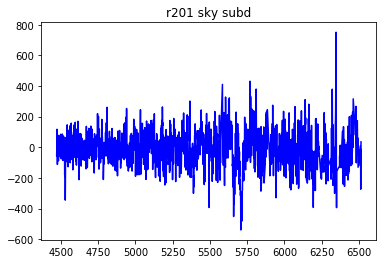

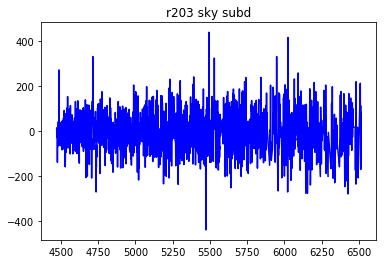

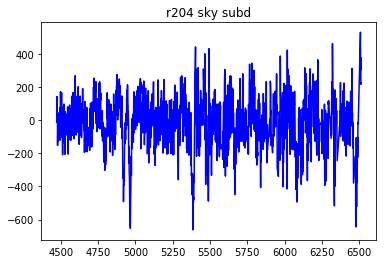

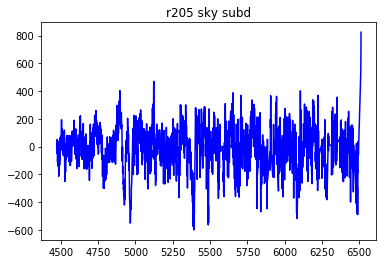

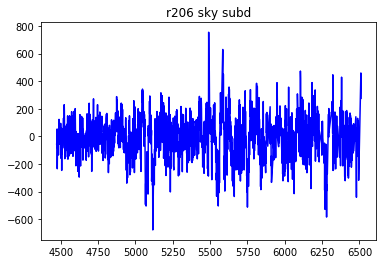

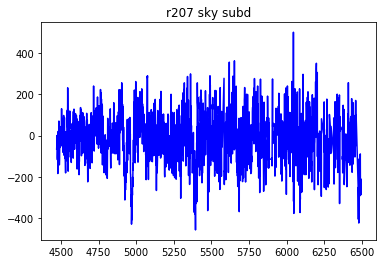

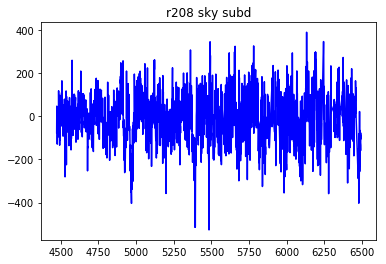

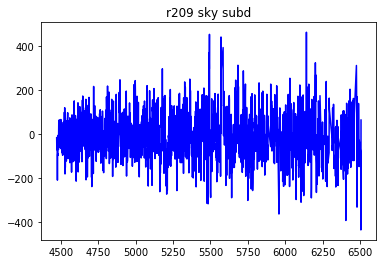

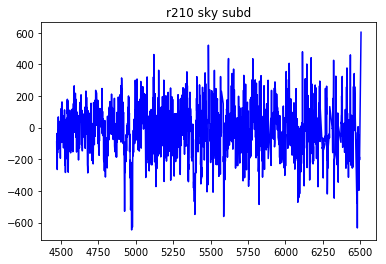

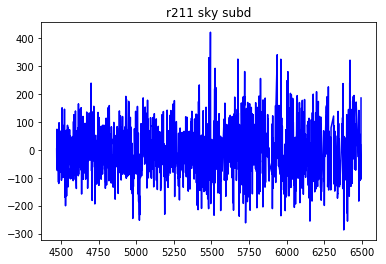

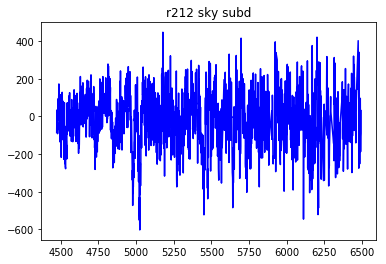

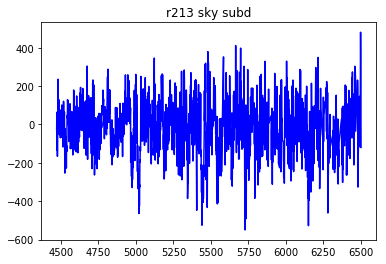

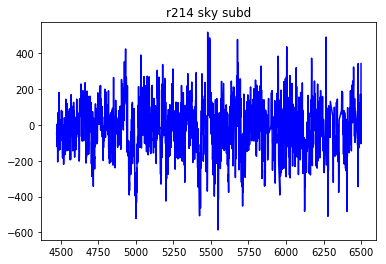

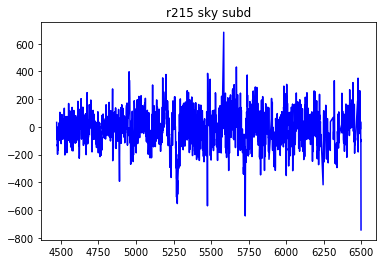

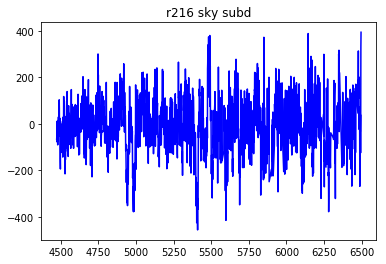

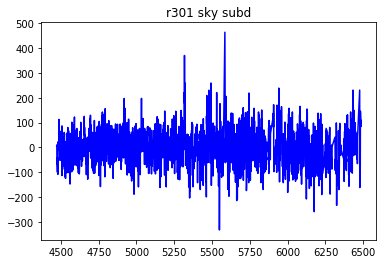

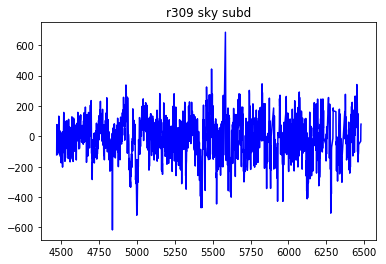

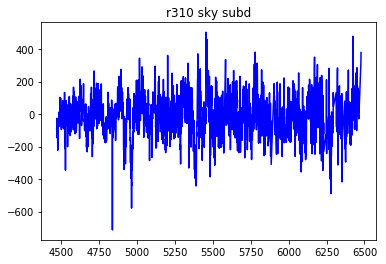

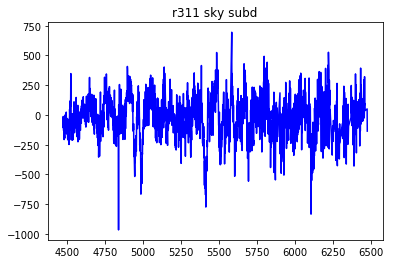

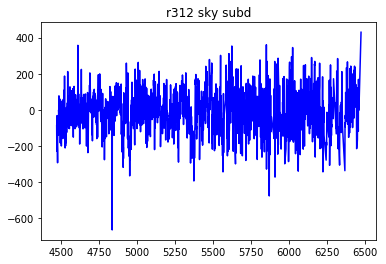

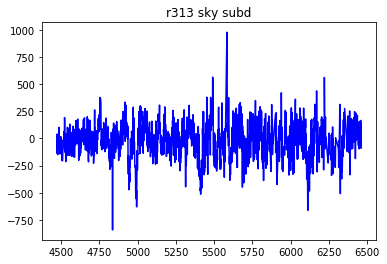

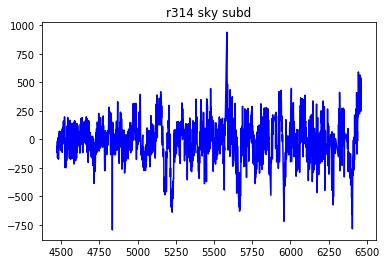

In [30]:
#intermaster = interp1d(uniform_waves,master_sky_flux,assume_sorted=True)
from scipy.signal import find_peaks
sky_subd_sciences = {}
intermaster = interp1d(*sciences['r202'],assume_sorted=True)
for ap in galaxies.keys():
    print(ap)
    waves,flux = sciences[ap]
    wave_cut_mask = ((waves>sciences['r202'][0][0])&(waves<sciences['r202'][0][-1]))
    waves = waves[wave_cut_mask]
    flux = flux[wave_cut_mask]
    itter_sky_flux = intermaster(waves)
    bool_mask = np.ones(shape = waves.size).astype(bool)
    peaks,properties = find_peaks(itter_sky_flux,height=1000)#,width=[0,10])
    #for peak,lwidth,rwidth in zip(peaks,properties['left_ips'],properties['right_ips']):
    #    bool_mask[int(peak-lwidth):int(peak+rwidth)] = False
    for peak,height in zip(peaks,properties['peak_heights']):
        width = np.log(height)/(2*np.log(np.e))
        bool_mask[int(peak-width):int(peak+width)] = False
    ratio = flux.max()/itter_sky_flux.max()
    itter_sky_flux *= ratio
    diff = flux-itter_sky_flux
    #plt.figure(), plt.subplots(figsize=(14,14))
    #plt.title(ap+ '  sky,gal comp')
    #plt.plot(waves,flux,'b-',alpha=0.5)
    #plt.plot(waves,itter_sky_flux,'r-',alpha=0.5)
    
    plt.figure()
    plt.title(ap+' sky subd')
    plt.plot(waves[bool_mask],diff[bool_mask],'b-')
    sky_subd_sciences[ap] = [waves,diff,bool_mask]

In [31]:
with open('skysubscience.pkl','wb') as pklout:
    pkl.dump([sky_subd_sciences,galaxies,skies,check_skies],pklout)

In [25]:
#sky_subd_sciences[ap] = [waves,diff,bool_mask]
%reload_ext zestipy
from zestipy.data_structures import waveform, redshift_data, smooth_waveform
from sncalc import sncalc
from zestipy.z_est import z_est
from zestipy.plotting_tools import summary_plot

In [26]:
R = z_est(lower_w=4200.0,upper_w=6400.0,lower_z=0.05,upper_z=0.6,\
          z_res=3.0e-5,prior_width=0.02,use_zprior=False,\
          skip_initial_priors=True,\
          auto_pilot=True)
     
template_names = ['spDR2-023.fit','spDR2-024.fit','spDR2-028.fit'] #['spDR2-0'+str(x)+'.fit' for x in np.arange(23,31)]
template_dir='sdss_templates'   #hack

path_to_temps = os.path.abspath(os.path.join(os.curdir,template_dir))  #hack
#Import template spectrum (SDSS early type) and continuum subtract the flux
R.add_sdsstemplates_fromfile(path_to_temps,template_names)

In [28]:
redshift_est, cor, template = {}, {}, {}
SNavg, SNHKmin, HSN, KSN, GSN = {}, {}, {}, {}, {}
for ap in sky_subd_sciences.keys():
    waves, flux, boolmask = sky_subd_sciences[ap]
    test_waveform = waveform(waves, flux, ap, boolmask)

    redshift_outputs = R.redshift_estimate(test_waveform)
    redshift_est[ap] = redshift_outputs.best_zest
    cor[ap] = redshift_outputs.max_cor
    ztest = redshift_outputs.ztest_vals
    corr_val = redshift_outputs.corr_vals
    template[ap] = redshift_outputs.template.name
    print((redshift_outputs.best_zest, redshift_outputs.max_cor, redshift_outputs.template.name))
    if not run_auto:
        qualityval['Clear'][ap] = redshift_outputs.qualityval
    try:
        HSN[ap], KSN[ap], GSN[ap] = sncalc(redshift_est[ap], test_waveform.wave,
                                           test_waveform.continuum_subtracted_flux)
    except ValueError:
        HSN[ap], KSN[ap], GSN[ap] = 0.0, 0.0, 0.0
    SNavg[ap] = np.average(np.array([HSN[ap], KSN[ap], GSN[ap]]))
    SNHKmin[ap] = np.min(np.array([HSN[ap], KSN[ap]]))
    # Create a summary plot of the best z-fit
    savestr = 'redEst_%s_Tmplt%s.png' % (test_waveform.name, redshift_outputs.template.name)
    plt_name = os.path.join(savedir, savestr)
    summary_plot(test_waveform.wave, test_waveform.flux, redshift_outputs.template.wave, \
                 redshift_outputs.template.flux, redshift_outputs.best_zest, redshift_outputs.ztest_vals, \
                 redshift_outputs.corr_vals, plt_name, test_waveform.name, None)

ValueError: x and y arrays must be equal in length along interpolation axis.

In [33]:
zbest = Table.read('./zfits/A02/redshifts.csv',format='ascii.csv',data_start=0,names=['zbest','cor','template'])
zbest

zbest,cor,template
float64,float64,str5
0.24278000000001443,0.6914490703840482,'028'
0.24641000000001473,0.5255750809121811,'023'
0.24710000000001475,0.6684092620485488,'028'
0.19421000000001082,0.6087113206004562,'023'
0.2486300000000149,0.6043778707171615,'023'
0.25619000000001546,0.5465105552434399,'023'
0.24686000000001473,0.6748375260146429,'028'
0.2797100000000172,0.41751790180750853,'023'
0.27881000000001716,0.7407943849603538,'028'


17 38 0.4473684210526316


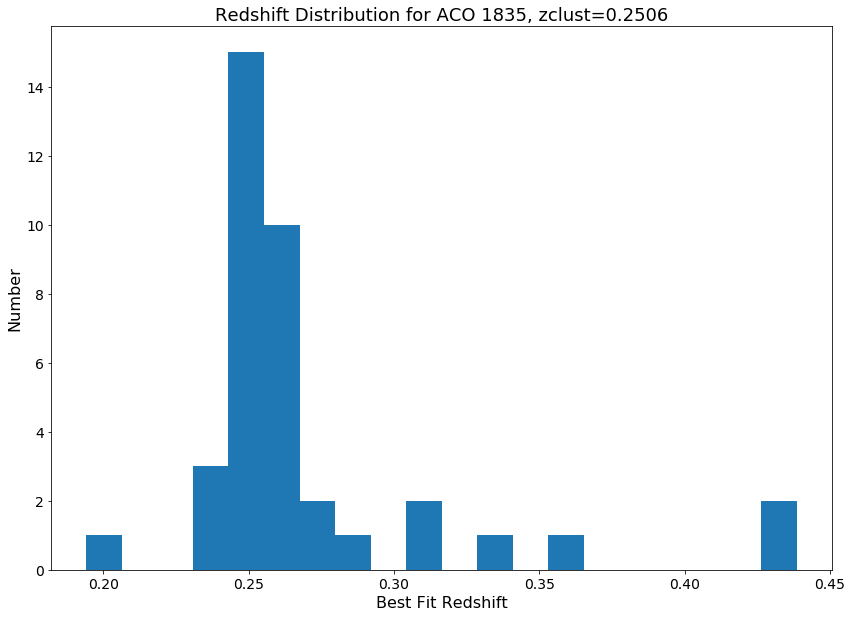

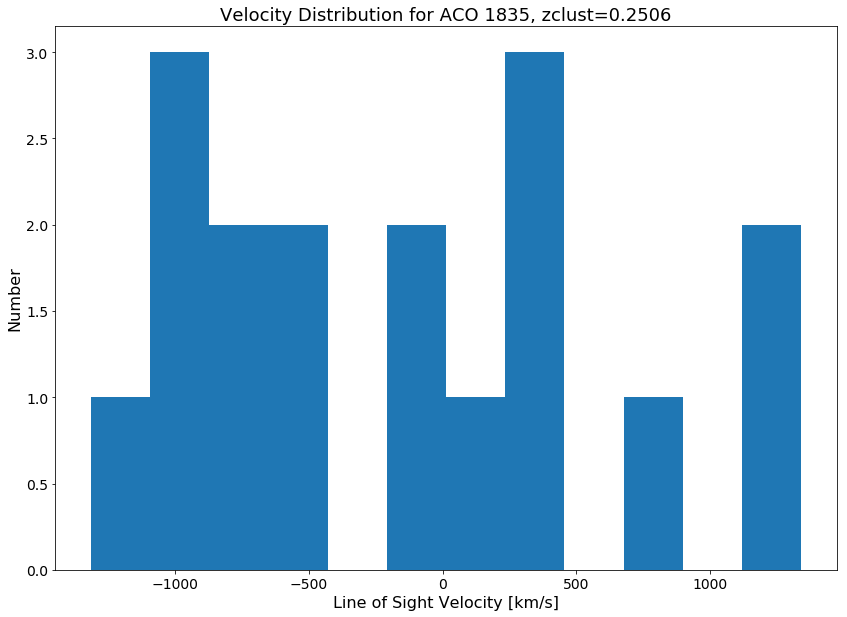

In [70]:
zclust = 0.2506
fig,ax = plt.subplots(figsize=(14,10))
format_plot(ax,title="Redshift Distribution for ACO 1835, zclust=0.2506",
           xlabel='Best Fit Redshift',
           ylabel='Number')
plt.hist(zbest['zbest'],bins=20)
plt.savefig(os.path.join(os.curdir,'zfits','A02','allredshifts_hist.png'))
fig, ax = plt.subplots(figsize=(14,10))
format_plot(ax,title="Velocity Distribution for ACO 1835, zclust=0.2506",
           xlabel='Line of Sight Velocity [km/s]',
           ylabel='Number')
#r'$\frac{zbest-zclust}{(1+zclust)}$*c'
zmz = 2.998e5*(zbest['zbest']-zclust)/(1+zclust)
cut = np.abs(zmz)<1500
print(np.sum(cut),len(zmz),np.sum(cut)/len(zmz))
plt.hist(zmz[cut],bins=12)
plt.savefig(os.path.join(os.curdir,'zfits','A02','veldisp_hist.png'))

In [ ]:
from quickreduce_funcs import pair_exposures
pair_exposures(dict_of_hdus,cams_same=True,max_matches=1)['r'][631]




In [ ]:


master_info['master_types'].append('twiflat')
#master_info['master_types'].append('fibmap')
filenumbers.pop('twiflat')
filenumbers.pop('fibmap')
load_info['tags'] = '.bc'
save_info['tags'] = '.bcf'
load_info['datadir'] = directory['product']
save_info['datadir'] = directory['product']


if load_data_from_disk_each_step or ('flat' == start):
        dict_of_hdus = get_all_filedata(filenum_dict=filenumbers, 
                                        **setup_info,**load_info,**master_info)
        print_data_neatly(dict_of_hdus)  
        blank_dictofdicts = get_dict_temp(dict_of_hdus)

In [ ]:


if do_step['flat']:
    for imtype in ['twiflat','fibmap']:
        for camera in cr_removed_data[imtype].keys():
            filenum_3d_array = np.asarray(list(data[imtype][camera].values()))
            header =list(headers[imtype][camera].values())[0]
            
            for exposure in range(filenum_3d_array.shape[0]):
                ## get exposure and make sure there are no negative values
                current_exposure = filenum_3d_array[exposure,:,:]
                current_exposure -= np.min(current_exposure)
                ## get a median smoothed version to remove any peculiarities, find it's max
                median_exposure = median_filter(current_exposure,size=5)
                ## divide by the max of the median exposure to normalize (excluding outliers)
                current_exposure /= np.max(median_exposure)
                filenum_3d_array[exposure,:,:] = current_exposure
            
            filenum_summed_array = np.median(filenum_3d_array,axis=0)
            header.add_history("Summed Master {} done by quickreduce on {}".format(imtype,date))

            outhdu = fits.PrimaryHDU(data=filenum_summed_array ,header=header)
            outname = master_info['master_templates'].format(cam=camera, imtype=imtype,maskname=mask_name, 
                                                           tags=save_info['tags'])
            filename = os.path.join(save_info['datadir'], outname)
            outhdu.writeto( filename ,overwrite=True)

            ## Plot the image
            plt.figure()
            plot_array = outhdu.data - np.min(outhdu.data) + 1e-4
            plt.imshow(np.log(plot_array),'gray',origin='lowerleft')
            plt.savefig(filename.replace('.fits','.png'),dpi=1200)
            plt.show()

            headers[imtype][camera] = header
            data[imtype][camera] = filenum_summed_array
            
    master_twiflat_data = data['twiflat']
    flat_data, flat_headers = {}, {}
    for imtype in filenumbers.keys():
        flat_data[imtype] = {}
        flat_headers[imtype] = {}
        for camera,master_twiflat in master_twiflat_data.items():
            master_twiflat /= np.max(master_twiflat)
            flat_data[imtype][camera] = {}
            flat_headers[imtype][camera] = {}
            datadict = data[imtype][camera]
            
            headerdict = headers[imtype][camera]
            for filnum,filearray in datadict.items():
                filearray = filearray.astype(float)
                header = headerdict[filnum]
                filearray /= master_twiflat.astype(float)
                header.add_history("Flat correction done by quickreduce on {}".format(date))
                outhdu = fits.PrimaryHDU(data=filearray ,header=header)
                filename = save_info['template'].format(cam=camera, imtype=imtype, 
                                                             maskname=mask_name, 
                                                             filenum=filnum, \
                                                             tags=save_info['tags'])
                filename = os.path.join(save_info['datadir'], filename)
                outhdu.writeto( filename ,overwrite=True)

                ## Plot the image
                plt.figure()
                plot_array = outhdu.data - np.min(outhdu.data) + 1e-4
                plt.imshow(np.log(plot_array),'gray',origin='lowerleft')
                plt.savefig(filename.replace('.fits','.png'),dpi=1200)
                plt.show() 
                
                flatnd_data[imtype][camera][filnum] = header
                flatnd_headers[imtype][camera][filnum] = filearray

    print("Completed flattening for {}".format(imtype))
    print("Results saved to {}".format(save_info['datadir']))
    del cr_removed_data, cr_removed_headers




In [ ]:


if load_data_from_disk_each_step or ('combine' == start):
        dict_of_hdus = get_all_filedata(filenum_dict=filenumbers, 
                                        **setup_info,**load_info,**master_info)
        print_data_neatly(dict_of_hdus)
        blank_dictofdicts = get_dict_temp(dict_of_hdus)




In [ ]:


if load_data_from_disk_each_step or ('zfit' == start):
        dict_of_hdus = get_all_filedata(filenum_dict=filenumbers, 
                                        **setup_info,**load_info,**master_info)
        print_data_neatly(dict_of_hdus)
        blank_dictofdicts = get_dict_temp(dict_of_hdus)

